In [1]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1' # CUDA 연산이 완료되기 전까지 다음 연산이 실행되지 않도록 하는 기능
os.environ['TORCH_USE_CUDA_DSA'] = '1'  # CUDA 연산의 메모리 사용량을 줄이고 성능을 향상시키는 기능

# 라이브러리 불러오기

In [4]:
!pip install torchvision
!pip install segmentation_models_pytorch
!pip install torch
!pip install cv2

     ---------------------------------------- 1.2/1.2 MB 9.5 MB/s eta 0:00:00
     -------------------------------------- 172.3/172.3 MB 4.5 MB/s eta 0:00:00
  Attempting uninstall: torch
    Found existing installation: torch 1.12.1
    Uninstalling torch-1.12.1:
      Successfully uninstalled torch-1.12.1
     -------------------------------------- 106.7/106.7 kB 3.0 MB/s eta 0:00:00
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
     ---------------------------------------- 58.8/58.8 kB ? eta 0:00:00
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
     -------------------------------------- 549.1/549.1 kB 8.7 MB/s eta 0:00:00
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16465 sha256=39232e6f396cf5178d82d3182aa0436cb032c58714434487b38ba5cd1debe927
  Stored in directory: c:\users\dnjse\appdata\local\pip\cache\wheels\13\d7\7

ERROR: Could not find a version that satisfies the requirement cv2 (from versions: none)
ERROR: No matching distribution found for cv2


In [2]:
import torch # 나도몰루
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from torchvision import transforms as T
import albumentations as A
from PIL import Image
import torch.nn.functional as F
import time
from tqdm.notebook import tqdm

from torch import nn
import segmentation_models_pytorch as smp
from torch.utils.data import Dataset

ModuleNotFoundError: No module named 'torchvision'

# 클래스 및 함수 정의

In [27]:
class Unet(nn.Module):                                        # UNet 클래스 정의
    def __init__(self, num_classes,encoder,pre_weight):       # 클래스의 필수 인자로 분류할 클래스 수, 인코더, 
                                                              # 사전학습 가중치 사용
        super().__init__()
        self.model = smp.Unet(classes = num_classes,          # smp(segmentation_models_pytorch)라이브러리의
                              encoder_name=encoder,           # UNet() 함수를 정의하고 파라미터로 클래스의 인자를 넣어줌
                              encoder_weights=pre_weight,
                              in_channels=3)
    
    def forward(self, x):
        y = self.model(x)                                     # model(UNet)을 y로 할당하고 인코더의 가중치로 'imagenet'을 사용,
        encoder_weights = "imagenet"                          # 최종적으로 y(모델) return
        return y

In [4]:
def create_df(IMAGE_PATH):                                             # 이미지 경로 및 파일 이름이 들어있는 데이터 프레임을 만듦
    name = []
    for dirname, _, filenames in os.walk(IMAGE_PATH):                  # 이미지가 들어있는 폴더 속의 파일이름들을 name 리스트에 차례로 넣음
        for filename in filenames:                                     # 이 때 .jpg나 .json 같은 확장자명은 제거함
            name.append(filename.split('.')[0])                        # id 컬럼을 가지고 행으로 파일 이름들을 가진 데이터 프레임 생성
    return pd.DataFrame({'id': name}, index = np.arange(0, len(name)))

In [5]:
class CarTestDataset(Dataset):                                    # 데이터셋 생성 클래스 CarTestDataset  
    def __init__(self, IMAGE_PATH, MASK_PATH, X, transform=None): # 클래스 인자로 이미지 경로, 마스크이미지 경로, X(파일명리스트), 변환인자
        self.IMAGE_PATH = IMAGE_PATH # 이미지 경로
        self.MASK_PATH = MASK_PATH   # 마스크이미지 경로
        self.X = X                   # 파일명 리스트 
        self.transform = transform   # 변환인자

    def __len__(self):               # 파일명 리스트 길이를 구하는 함수: 데이터 세트의 길이를 볼 수 있음
        return len(self.X)

    def __getitem__(self, idx):                                                        # 데이터세트 데이터 추가하는 함수, 인자로는 인덱스
        img = cv2.imread(self.IMAGE_PATH + self.X[idx] + '.jpg')                       # 파일명 리스트의 인덱스에 맞춘 이미지 불러오기
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)                                     # OpenCV의 원래 BGR이였던 색상배열을 RGB로 변환
        mask = cv2.imread(self.MASK_PATH + self.X[idx] + '.jpg', cv2.IMREAD_GRAYSCALE) # 마스크이미지 불러오기, 대신 흑백(0~255)이미지로

        if self.transform is not None:                    # 변환인자가 있으면      
            aug = self.transform(image=img, mask=mask)    # 이미지와 마스크이미지에 변환 인자 적용 => Numpy 배열타입
            img = Image.fromarray(aug['image'])           # numpy 배열인 aug['img']를 이미지로 변환하여 img에 할당
            mask = aug['mask']                            # 마스크이미지는 numpy 배열로 할당

        if self.transform is None:                        # 변환인자가 없으면
            img = Image.fromarray(img)                    # numpy 배열을 이미지로 변환 후 img에 할당

        # mask의 값이 0이 아닌 경우 1로 변환
        mask = torch.from_numpy(mask)                     # mask를 numpy 배열로 변환(원래 np배열이라서 상관 x)
        mask[mask != 0] = 1                               # mask가 0이 아니면 1로 설정하여 이진화
        mask = mask.long()                                # 이유: IMREAD_GRAYSCALE은 흑백이미지로 흰~검정으로 가는 255개 색상?밝기?를 갖기 때문

        return img, mask # 이미지 형식의 이미지와 numpy 배열 형태인 마스크 반환

In [6]:
def pixel_accuracy(output, mask): # 정확도 연산 함수, 인자로는 output(model에 input을 넣은 결과값), 마스크
    with torch.no_grad(): # 모델이 역전파를 통해 가중치를 업데이트하는 과정에 사용되는 기울기를 계산하지 않게 설정
        output = torch.argmax(F.softmax(output, dim=1), dim=1)  # output에 softmax 함수를 적용한 결과 중 가장 큰 값에 해당하는 클래스의 인덱스 추출
        correct = torch.eq(output, mask).int()                  # output과 mask를 비교하여 예측한 클래스와 실제 클래스가 같으면 '1' 아니면 '0'으로 구성된 이진 텐서(correct) 생성
        accuracy = float(correct.sum()) / float(correct.numel())# correct 전체 원소 합계와 correct 원소 개수를 나누어 정확도 산출
    return accuracy                                             # accuracy(정확도) 반환

def mIoU(pred_mask, mask, smooth=1e-10, n_classes=2): # mIoU 연산 함수, 인자로는 예측한 마스크 tensor, 원본 마스크 tensor, smooth(?), 클래스 수
    with torch.no_grad():                             # 기울기 계산 X
        pred_mask = F.softmax(pred_mask, dim=1)       # 예측 마스크 tensor에 softmax함수를 2번째 차원에 적용
        pred_mask = torch.argmax(pred_mask, dim=1)    # softmax 함수 결과 중 가장 큰 값에 해당하는 클래스의 인덱스 추출
        pred_mask = pred_mask.contiguous().view(-1)   # 예측 마스크 tensor를 연속적 형태로 만들어 접근속도 높이는 작업
        mask = mask.contiguous().view(-1)             # 마스크 tensor도 똑같이 적용

        iou_per_class = []
        for clas in range(0, n_classes): #loop per pixel class
            true_class = pred_mask == clas # 예측 마스크가 clas(0, 1)이랑 같으면 true_class
            true_label = mask == clas      # 마스크가 clas(0, 1)이랑 같으면 true_label

            if true_label.long().sum().item() == 0: # 만일 실제 마스크가 for문에 존재하지 않으면
                iou_per_class.append(np.nan)        # IoU 대신 NaN(결측치)을 리스트에 추가
            else:
                intersect = torch.logical_and(true_class, true_label).sum().float().item() # 실제 클래스(세그먼트)와 예측 클래스(세그먼트) 간 겹치는 교집합 만듦
                union = torch.logical_or(true_class, true_label).sum().float().item()      # 실제 클래스(세그먼트)와 예측 클래스(세그먼트) 간 합집합 만듦

                iou = (intersect + smooth) / (union +smooth) # IoU가 교집합/합집합인데, smooth는 일부러 오차를 넣은것 같은데 왜 넣었는지는 모르겠음. 정수로 안되게 하려고 한건가
                iou_per_class.append(iou) # 클래스가 0일 때의 IoU, 클래스가 1일 때의 IoU를 리스트에 저장
        return np.nanmean(iou_per_class)  # 결측치를 제외한 IoU 평균 return

In [7]:
def predict_image_mask_pixel(model, image, mask, mean = [0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]): # T.Noramlize를 위함. 원래는 채널별로 계산해야하지만 mIoU 값이 제대로 나오지 않아 general하게 사용되는 0.5를 기본값으로 넣었음
    model.eval() # 한 이미지당 마스크(픽셀별)를 예측하는 함수, 인자로는 모델, 이미지, 원본 마스크, 채널별 평균, 채널별 표준편차
    t = T.Compose([T.ToTensor(), T.Normalize(mean, std)]) # 이미지를 Tensor 타입으로 변환 후 Normalize 적용
    image = t(image)
    model.to(device); image=image.to(device) # 디바이스에 옮긴다?라는 뜻 
    mask = mask.to(device) # 마스크도 한 디바이스로 옮김
    with torch.no_grad(): # 기울기 계산 X
        image = image.unsqueeze(0)  # 이미지 텐서의 차원 확장, 0은 1차원 확장  ex) (C,H,W) -> (1,C,H,W)
        mask = mask.unsqueeze(0)    # 마스크 텐서의 차원 확장 
        
        output = model(image)               # 모델 결과값 할당
        acc = pixel_accuracy(output, mask)  # 앞서 pixel_acurracy 함수를 통한 하나의 이미지의 정확도 산출
        masked = torch.argmax(output, dim=1)# output 결과 중 가장 큰 값에 해당하는 클래스의 인덱스 추출? 
        masked = masked.cpu().squeeze(0)    # 1차원 줄여줌
    return masked, acc                      # 예측 마스크 tensor, 정확도 return

def predict_image_mask_miou(model, image, mask, mean = [0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]):
    model.eval() # 위의 함수와 같은 기능, 대신 정확도를 산출하는 것이 아닌 mIoU를 산출
    t = T.Compose([T.ToTensor(), T.Normalize(mean, std)])
    image = t(image)
    model.to(device); image=image.to(device)
    mask = mask.to(device)
    with torch.no_grad():    
        image = image.unsqueeze(0)
        mask = mask.unsqueeze(0)
        
        output = model(image)
        score = mIoU(output, mask)
        masked = torch.argmax(output, dim=1)
        masked = masked.cpu().squeeze(0)
        masked_probs = torch.softmax(output, dim=1)
        masked_probs = masked_probs.cpu().squeeze(0)
    return masked, masked_probs, score 

In [8]:
def miou_score(model, test_set):                                                 # mIoU 연산 함수, 인자로 모델, 데이터 세트
    score_iou = []
    for i in tqdm(range(len(test_set))):                                         # dm: 시간바 생성
        img, mask = test_set[i]                                                  # 테스트 세트의 인덱스별 이미지, 마스크 변수 생성
        pred_mask, pred_probs, score = predict_image_mask_miou(model, img, mask) # 예측을 통해 예측마스크 배열, 클래스에 속할 확률, mIoU 산출 
        score_iou.append(score)                                                  # score_iou 리스트에 mIoU 추가
    return score_iou                                                             # 모든 테스트 데이터에 대한 mIoU 리스트 return

def pixel_acc(model, test_set):                                                  # 픽셀별 정확도 연산 함수, 인자로 모델, 데이터 세트
    accuracy = []
    for i in tqdm(range(len(test_set))):                                         # dm: 시간바 생성
        img, mask = test_set[i]                                                  # 테스트 세트의 인덱스별 이미지, 마스크 변수 생성
        pred_mask, acc = predict_image_mask_pixel(model, img, mask)              # 예측을 통해 예측마스크 배열, 정확도 산출
        accuracy.append(acc)                                                     # accuracy 리스트에 정확도(accuracy) 추가
    return accuracy                                                              # 모슨 테스트 데이터에 대한 acurracy 리스트 return

# 모델 불러오기

In [28]:
pt_lst = ['scractchunet.pt', 'seperateunet.pt', 'crushedunet.pt', 'breakageunet.pt'] # 사전학습모델 4개 정의
models = []

n_classes = 2 # 클래스 개수 정의(픽셀당 클래스를 2개로 나눠야함, scratch/separate/crush/breakage 중 하나와 배경)
device = 'cuda' if torch.cuda.is_available() else 'cpu' # cpu 대신 GPU(Cuda) 사용

for label in pt_lst:
    model_path = f'./weightmodel/{label}' # 
    model = Unet(encoder='resnet34', pre_weight='imagenet', num_classes=n_classes).to(device)
    model.model.load_state_dict(torch.load(model_path, map_location=torch.device(device)))
    # 저장된 모델 가중치를 불러와 모델에 로드
    model.eval()
    # 모델을 평가 모드로 설정 (테스트나 추론을 수행할 때 사용되는 모드)
    models.append(model)
    print(f'{label} is loaded!')
    
# Scratched, Separated, Crushed, Breakage 총 4개의 사전학습된 모델을 불러옴
# Unet은 이미지 size를 줄여주는 Encoder와 이미지 size를 늘리는 Decoder로 분류될 수 있는데, Encoder 부분에는
# 또 다른 CNN 모델의 구조를 불러와서 사용할 수 있음 ex) ResNet, EfficientNet 등
# 사전 학습된 모델은 Unet()함수의 pre_weight 인자에 가중치로 사용됨
# 기본은 imagenet으로 imagenet 데이터셋으로 사전학습된 가중치를 사용하나, model.load_state_dict를 통해 
# AI hub에서 제공하는 사전학습된 모델을 가중치로 사용

print('Loaded pretrained models!')

scractchunet.pt is loaded!
seperateunet.pt is loaded!
crushedunet.pt is loaded!
breakageunet.pt is loaded!
Loaded pretrained models!


# 이미지 경로 설정

In [10]:
IMAGE_PATH_sc= './sample/mask_data/scratched/'  # Scratched 원본 이미지 파일 경로
MASK_PATH_sc = './sample/mask_label/scratched/' # Scratched 마스크 이미지 파일 경로

IMAGE_PATH_se = './sample/mask_data/separated/' # Separated 원본 이미지 파일 경로 
MASK_PATH_se = './sample/mask_label/separated/' # Separated 마스크 이미지 파일 경로

IMAGE_PATH_br = './sample/mask_data/breakage/'  # Breakage 원본 이미지 파일 경로
MASK_PATH_br = './sample/mask_label/breakage/'  # Breakage 마스크 이미지 파일 경로

IMAGE_PATH_cr = './sample/mask_data/crushed/'   # Crushed 원본 이미지 파일 경로
MASK_PATH_cr = './sample/mask_label/crushed/'   # Crushed 마스크 이미지 파일 경로

In [11]:
df_sc = create_df(IMAGE_PATH_sc) # Scratch 이미지 폴더의 파일 리스트 데이터프레임으로 생성
df_se = create_df(IMAGE_PATH_se) # Separated  " 
df_br = create_df(IMAGE_PATH_br) # Breakage  "
df_cr = create_df(IMAGE_PATH_cr) # Crush  "

# 테스트 데이터 셋 생성

In [12]:
test_sc = df_sc['id'].values # Scratched 확장자 제외한 파일명 리스트 test_sc 변수명에 할당
test_se = df_se['id'].values # Separated "
test_br = df_br['id'].values # Breakage  "
test_cr = df_cr['id'].values # Crushed   "

t_test = A.Resize(576, 576) # 이미지 사이즈 (576 * 576)으로 조정하는 옵션

test_set_sc = CarTestDataset(IMAGE_PATH_sc, MASK_PATH_sc, test_sc, transform = t_test) # Scratched 분류를 위한 dataset 생성
test_set_se = CarTestDataset(IMAGE_PATH_se, MASK_PATH_se, test_se, transform = t_test) # Separated 분류를 위한 dataset 생성
test_set_br = CarTestDataset(IMAGE_PATH_br, MASK_PATH_br, test_br, transform = t_test) # Breakage 분류를 위한 dataset 생성
test_set_cr = CarTestDataset(IMAGE_PATH_cr, MASK_PATH_cr, test_cr, transform = t_test) # Crushed 분류를 위한 dataset 생성

In [13]:
print(f'Scratch: {test_set_sc.__len__()}')  # Scratch 이미지 세트 장수
print(f'Separate: {test_set_se.__len__()}') # Separate 이미지 세트 장수
print(f'Crush: {test_set_cr.__len__()}')    # Crushed 이미지 세트 장수
print(f'Breakage: {test_set_br.__len__()}') # Breakage 이미지 세트 장수

Scratch: 1029
Separate: 381
Crush: 245
Breakage: 395


# 예측

In [14]:
mob_miou_sc = miou_score(models[0], test_set_sc) # Scratched UNet 모델로 예측한 인덱스별 Scratched: mIoU 리스트 산출
mob_miou_se = miou_score(models[1], test_set_se) # Separated  "
mob_miou_cr = miou_score(models[2], test_set_cr) # Crushed  "
mob_miou_br = miou_score(models[3], test_set_br) # Breakage  "

  0%|          | 0/1029 [00:00<?, ?it/s]

  0%|          | 0/381 [00:00<?, ?it/s]

  0%|          | 0/245 [00:00<?, ?it/s]

  0%|          | 0/395 [00:00<?, ?it/s]

In [15]:
mob_acc_sc = pixel_acc(models[0], test_set_sc) # Scratched UNet 모델로 예측한 인덱스별 Scratched: Accuracy 리스트 산출
mob_acc_se = pixel_acc(models[1], test_set_se) # Separated  "
mob_acc_cr = pixel_acc(models[2], test_set_cr) # Crushed  "
mob_acc_br = pixel_acc(models[3], test_set_br) # Breakage  "

  0%|          | 0/1029 [00:00<?, ?it/s]

  0%|          | 0/381 [00:00<?, ?it/s]

  0%|          | 0/245 [00:00<?, ?it/s]

  0%|          | 0/395 [00:00<?, ?it/s]

# 성능평가

## mIOU 

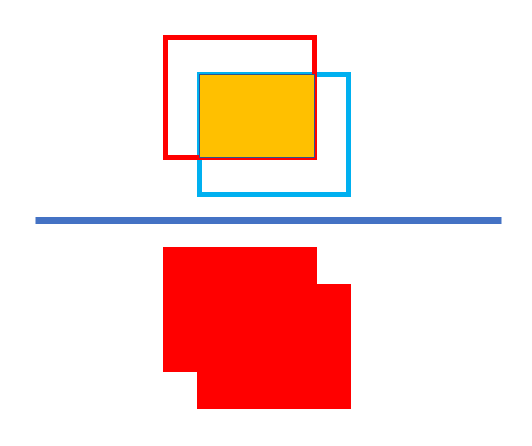
### - IOU = (예측 영역과 정답 영역의 교집합) / (예측 영역과 정답 영역의 합집합)
### - mIOU는 각 이미지의 IOU를 평균한 값

In [16]:
print('Scratch mIoU', round(np.mean(mob_miou_sc),4))  # Scratched mIoU : 0.526
print('Separate mIoU', round(np.mean(mob_miou_se),4)) # Separated mIoU : 0.5073
print('Crush mIoU', round(np.mean(mob_miou_cr),4))    # Crushed mIoU : 0.5108
print('Breakage mIoU', round(np.mean(mob_miou_br),4)) # Breakage mIoU : 0.4059

Scratch mIoU 0.526
Separate mIoU 0.5073
Crush mIoU 0.5108
Breakage mIoU 0.4059


In [17]:
print('Scratch Pixel Accuracy', round(np.mean(mob_acc_sc),4))  # Scratched 정확도 : 95.22%
print('Separate Pixel Accuracy', round(np.mean(mob_acc_se),4)) # Separated 정확도 : 94.29%
print('Crush Pixel Accuracy', round(np.mean(mob_acc_cr),4))    # Crushed 정확도 : 95.09%
print('Breakage Pixel Accuracy', round(np.mean(mob_acc_br),4)) # Breakage 정확도 : 74.72%

Scratch Pixel Accuracy 0.9522
Separate Pixel Accuracy 0.9429
Crush Pixel Accuracy 0.9509
Breakage Pixel Accuracy 0.7472


# 샘플 살펴보기

In [18]:
image_sc, mask_sc = test_set_sc[357] # Scratched 중 mIoU가 가장 높은 테스트 데이터의 이미지, 마스크 추출
image_se, mask_se = test_set_se[291] # Separated 중 mIoU가 가장 높은 테스트 데이터의 이미지, 마스크 추출
image_cr, mask_cr = test_set_cr[89]  # Crushed 중 mIoU가 가장 높은 테스트 데이터의 이미지, 마스크 추출
image_br, mask_br = test_set_br[159] # Breakage 중 mIoU가 가장 높은 테스트 데이터의 이미지, 마스크 추출

pred_mask_sc, pred_probs_sc, score_sc = predict_image_mask_miou(models[0], image_sc, mask_sc) # Scratched 모델로 예측 마스크 배열, 픽셀별 클래스에 속할 확률,  산출
pred_mask_se, pred_probs_se, score_se = predict_image_mask_miou(models[1], image_se, mask_se) # Separated 모델로 예측 마스크의 배열, 픽셀별 클래스에 속할 확률예측 마스크 값 산출
pred_mask_cr, pred_probs_cr, score_cr = predict_image_mask_miou(models[2], image_cr, mask_cr) # Crushed 모델로 예측 마스크의  산출
pred_mask_br, pred_probs_br, score_br = predict_image_mask_miou(models[3], image_br, mask_br) # Breakage 모델로 예측 마스크 배열  산출

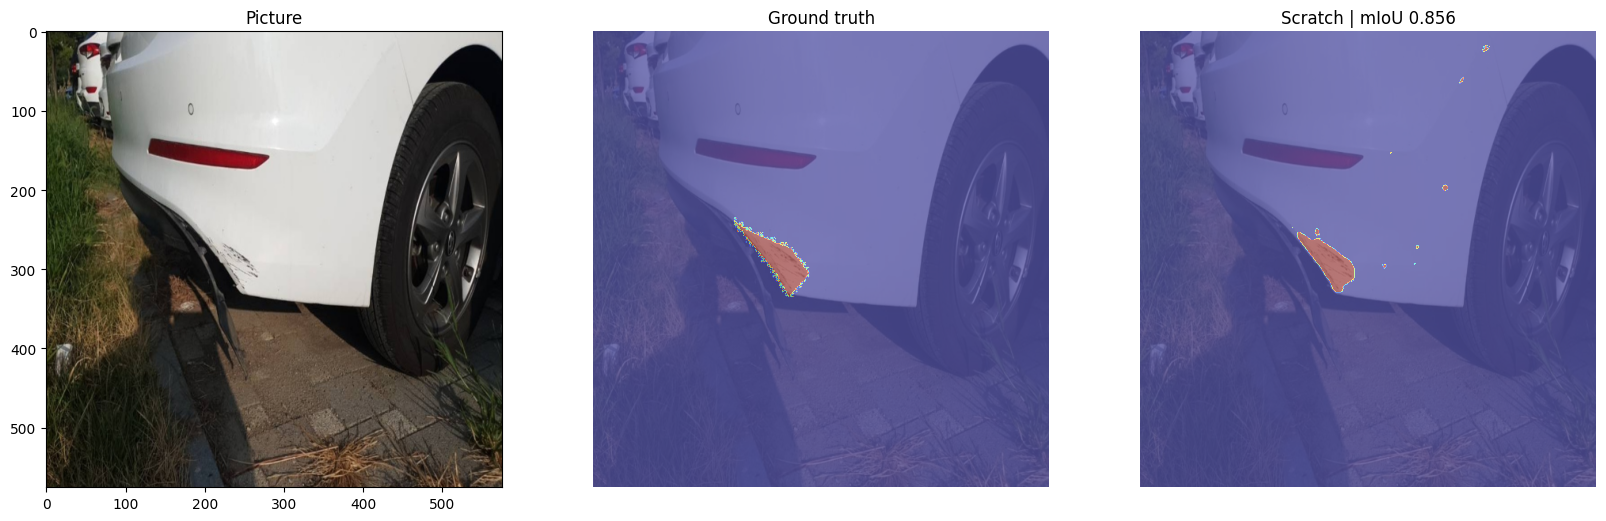

In [19]:
# Scratched (스크래치)
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(20,10))     # 1행 3열, (20, 10) 크기를 가진 캔버스 생성
ax1.imshow(image_sc)                                          # 클래스가 Scratched인 이미지 시각화
ax1.set_title('Picture');                                     # 제목은 Picture(원본 이미지)

ax2.imshow(image_sc, alpha = 0.5)                             # 원본 이미지 시각화
ax2.imshow(mask_sc, cmap = 'jet', alpha=0.5)                  # 원본 이미지 위에 마스크 이미지를 덮어씌움(이 때 투명도 50%, 색은 jet)
ax2.set_title('Ground truth')                                 # 제목은 Ground Truth(원본 이미지의 마스크)
ax2.set_axis_off()

ax3.imshow(image_sc, alpha = 0.5)                             # 원본 이미지 시각화
ax3.imshow(pred_mask_sc, cmap = 'jet', alpha = 0.5)           # 원본 이미지 위에 모델로 예측한 마스크 이미지를 덮어씌움(옵션 동일)
ax3.set_title('Scratch | mIoU {:.3f}'.format(score_sc))       # Scratch 분류 모델의 원본 이미지에 대한 mIoU 계산값을 제목으로
ax3.set_axis_off()                                            # 아래 셀부터 모두 형식은 동일, 데이터와 모델만 각각 Separated, Crushed, Breakage로 다름

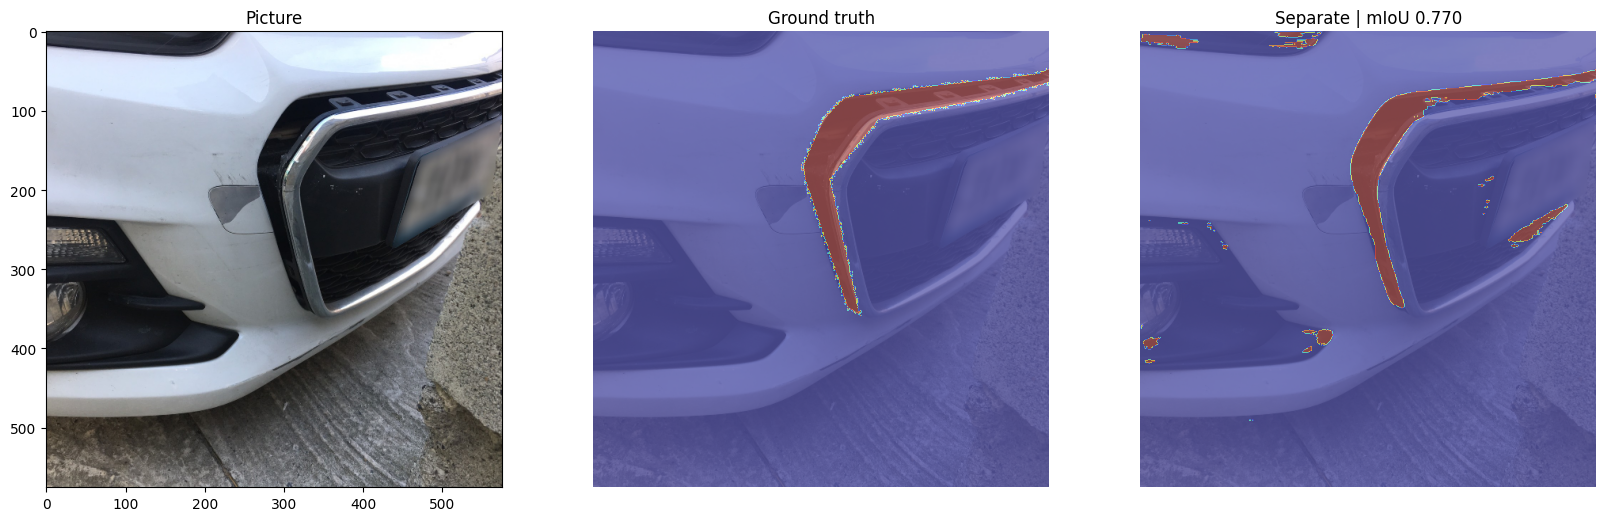

In [20]:
# Separated (이격)
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(20,10))
ax1.imshow(image_se)
ax1.set_title('Picture');

ax2.imshow(image_se, alpha = 0.5)
ax2.imshow(mask_se, cmap = 'jet', alpha=0.5)
ax2.set_title('Ground truth')
ax2.set_axis_off()

ax3.imshow(image_se, alpha = 0.5)
ax3.imshow(pred_mask_se, cmap = 'jet', alpha = 0.5)
ax3.set_title('Separate | mIoU {:.3f}'.format(score_se))
ax3.set_axis_off()

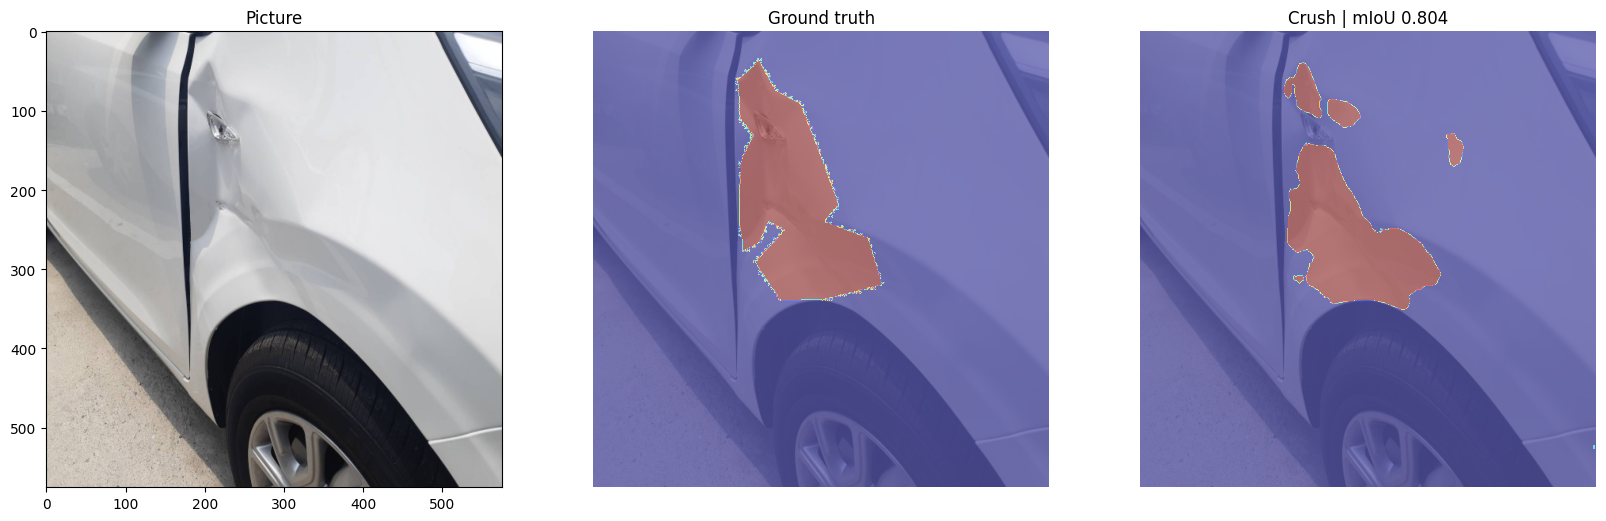

In [21]:
# Crushed (찌그러짐)
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(20,10))
ax1.imshow(image_cr)
ax1.set_title('Picture');

ax2.imshow(image_cr, alpha = 0.5)
ax2.imshow(mask_cr, cmap = 'jet', alpha=0.5)
ax2.set_title('Ground truth')
ax2.set_axis_off()

ax3.imshow(image_cr, alpha = 0.5)
ax3.imshow(pred_mask_cr, cmap = 'jet', alpha = 0.5)
ax3.set_title('Crush | mIoU {:.3f}'.format(score_cr))
ax3.set_axis_off()

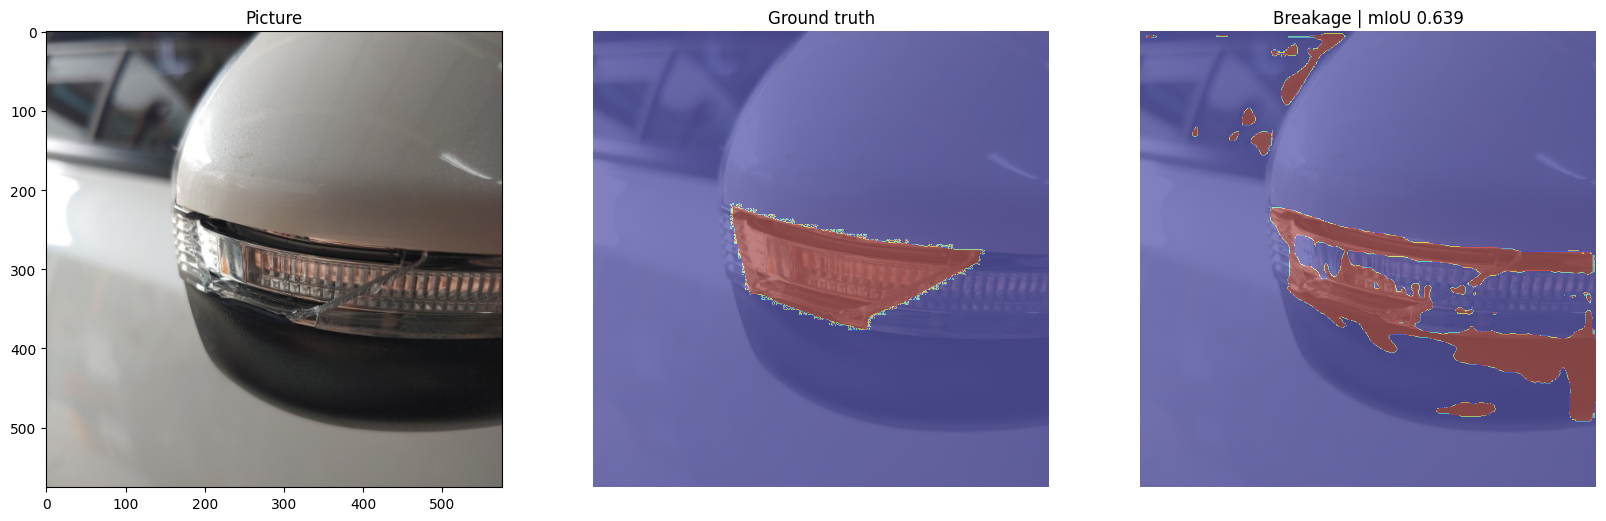

In [22]:
# Breakage (파손)
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(20,10))
ax1.imshow(image_br)
ax1.set_title('Picture');

ax2.imshow(image_br, alpha = 0.5)
ax2.imshow(mask_br, cmap = 'jet', alpha=0.5)
ax2.set_title('Ground truth')
ax2.set_axis_off()

ax3.imshow(image_br, alpha = 0.5)
ax3.imshow(pred_mask_br, cmap = 'jet', alpha = 0.5)
ax3.set_title('Breakage | mIoU {:.3f}'.format(score_br))
ax3.set_axis_off()

In [23]:
pwd

'/home/piai/AI_project_C1'

# 모델 저장

In [37]:
model_path = f'./weightmodel/{pt_lst[0]}' # 
model = Unet(encoder='resnet34', pre_weight='imagenet', num_classes=n_classes).to(device)
model.model.load_state_dict(torch.load(model_path, map_location=torch.device(device)))
# 저장된 모델 가중치를 불러와 모델에 로드
model.eval()

Unet(
  (model): Unet(
    (encoder): ResNetEncoder(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (1): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2

In [47]:
torch.save(model, 'scratched.pth')

In [50]:
model_path = f'./weightmodel/{pt_lst[1]}' # 
model = Unet(encoder='resnet34', pre_weight='imagenet', num_classes=n_classes).to(device)
model.model.load_state_dict(torch.load(model_path, map_location=torch.device(device)))
# 저장된 모델 가중치를 불러와 모델에 로드
model.eval()
torch.save(model, 'separated.pth')


model_path = f'./weightmodel/{pt_lst[2]}' # 
model = Unet(encoder='resnet34', pre_weight='imagenet', num_classes=n_classes).to(device)
model.model.load_state_dict(torch.load(model_path, map_location=torch.device(device)))
# 저장된 모델 가중치를 불러와 모델에 로드
model.eval()
torch.save(model, 'crushed.pth')

model_path = f'./weightmodel/{pt_lst[3]}' # 
model = Unet(encoder='resnet34', pre_weight='imagenet', num_classes=n_classes).to(device)
model.model.load_state_dict(torch.load(model_path, map_location=torch.device(device)))
# 저장된 모델 가중치를 불러와 모델에 로드
model.eval()
torch.save(model, 'breakage.pth')